In [1]:
import pandas as pd

# Read data
df = pd.read_excel("MyFoodData.xlsx")

# Drops unrelevant columns
df = df.filter(items = ["Name", "Calories", "Protein (g)"])
df.head()

,Name,Calories,Protein (g)
0,Pillsbury Golden Layer Buttermilk Biscuits Art...,307.0,5.88
1,Pillsbury Cinnamon Rolls With Icing Refrigerat...,330.0,4.34
2,Kraft Foods Shake N Bake Original Recipe Coati...,377.0,6.10
3,George Weston Bakeries Thomas English Muffins,232.0,8.00
4,Waffles Buttermilk Frozen Ready-To-Heat,273.0,6.58


In [ ]:
def calculateFitness(chromosome: list, maxWeight: int, negative: bool, penaltyFactor: int = 100):
    totalValue = 0
    totalWeight = 0

    for i in range(len(chromosome)):
        if chromosome[i] == 1:
            value = df.iloc[i]['Protein (g)']
            totalValue += value
            
            weight = df.iloc[i]['Calories']
            totalWeight += weight
    
    proteinWeight = 10
    # Penalty if the weight exceeds maxWeight
    if totalWeight > maxWeight:
        penalty = (totalWeight - maxWeight) ** penaltyFactor
        fitness = proteinWeight * totalValue - penalty
    # No penalty
    else:
        fitness = proteinWeight * totalValue

    if (negative):
        finalFitness = fitness
    else:
        max(1, fitness)
        
    return finalFitness

In [3]:
import random

def generateIndividualWithLimit(chromosomeSize: int, maxCalories: int):
    chromosome = [0] * chromosomeSize
    indices = list(range(chromosomeSize))
    random.shuffle(indices)

    totalCalories = 0
    for i in indices:
        calorie = df.iloc[i]['Calories']
        if totalCalories + calorie <= maxCalories:
            chromosome[i] = 1
            totalCalories += calorie
        else:
            break
    return chromosome


In [4]:
import random 

def initializePopulation(populationSize: int, chromosomeSize: int, seed: int = None):
    population = []

    # Set seed
    if seed is not None:
        random.seed(seed)

    # Randomly generate populationSize amount of chromosomes with chromosomeSize size
    for i in range(populationSize):
        member = [random.randint(0, 1) for i in range(chromosomeSize)]
        population.append(member)
    
    random.seed(None)
    
    return population

def initializePopulationWithMaxWeight(populationSize: int, chromosomeSize: int, maxCalories: int, seed: int = None, rate: float = 1):
    population = []

    # Set seed
    if seed is not None:
        random.seed(seed)

    # Randomly generate populationSize amount of chromosomes with chromosomeSize size
    for i in range(int(populationSize * rate)):
        member = [random.randint(0, 1) for i in range(chromosomeSize)]
        population.append(member)
    
    while len(population) != populationSize:
        member = generateIndividualWithLimit(chromosomeSize, maxCalories)
        population.append(member)
        
    random.seed(None)
    
    return population



In [5]:
def sortPopulation(population: list[list], maxWeight: int, negative: bool, penaltyFactor: int = 1.5):
    return sorted(population, key=lambda individual: calculateFitness(individual, maxWeight, negative, penaltyFactor), reverse=True)


In [6]:
def rouletteWheelSelection(population: list[list], maxWeight: int, penaltyFactor: int = 1.5):
    total_fitness = 0
    fitnesses = []

    # Add all fitnesses
    for i in population:
        # Negative fitness is not allowed
        fitness = calculateFitness(i, maxWeight, False, penaltyFactor)
        fitnesses.append(fitness)
        total_fitness += fitness

    # An individual in the population have fitness / (sum of all fitnesses) chance to be selected in the Roulette Wheel Selection
    prob_sum = 0
    # Random float as roulette
    roulette = random.uniform(0, total_fitness)
    for i in range(len(population)):
        # If the prob_sum + fitness of the individual exceedes the roulette value, the roulette is in that probability area, so the individual is selected
        # Example:
        # If we have 5 individuals with fitness values 5, 10, 15, 6, 3 and roulette as 21, the individual with fitness value 15 should be selected.
        # In the first iteration of the loop prob_sum would be 5, in the second iteration 15 and in the third iteration it would be 30, exceeding the roulette value
        # Third individual from the population would be selected according to this algorithm
        prob_sum += fitnesses[i]
        if prob_sum > roulette:
            return population[i]

        

In [7]:
def tournamentSelection(population: list[list], tournamentSize: int, maxWeight: int, penaltyFactor: int = 1.5):
    # tournamentSize amount of individuals are selected for the tournament
    randomIndividuals = random.sample(range(0, len(population)), tournamentSize)
    bestFitness = -1
    bestIndividual = []
    #print(randomIndividuals)
    
    for i in randomIndividuals:
        # Individual with best fitness wins the tournament
        # This individual is selected
        fitness = calculateFitness(population[i], maxWeight, False, penaltyFactor)
        #print(f"Individual {i}, fitness {fitness}")
        if fitness > bestFitness:
            bestFitness = fitness
            bestIndividual = i
    return population[bestIndividual]


In [8]:
population = initializePopulation(10, 5)

bestIndividual = tournamentSelection(population, 4, 2500)
print(bestIndividual)

[1, 0, 0, 1, 1]


In [10]:
import random

def singlePointCrossover(firstParent: list, secondParent: list):

   # Selects a random crossover point
   crossOverPoint = random.randint(1, len(firstParent) - 1)

   # Selects the crossover parts from parents (From random point to end of the chromosome)
   crossOverPart1 = firstParent[crossOverPoint: len(firstParent)]
   crossOverPart2 = secondParent[crossOverPoint: len(secondParent)]

   firstOffspring = firstParent
   secondOffspring = secondParent

   # Swaps the crossover parts between parents
   firstOffspring[crossOverPoint: len(firstParent)] = crossOverPart2
   secondOffspring[crossOverPoint: len(secondParent)] = crossOverPart1

   return [firstOffspring, secondOffspring]

In [11]:
firstParent = [0, 0 , 1, 1, 0, 1]
secondParent = [1, 1, 0, 0, 0, 1]

offsprings = singlePointCrossover(firstParent, secondParent)
print(offsprings)

[[0, 0, 0, 0, 0, 1], [1, 1, 1, 1, 0, 1]]


In [12]:
def multiplePointCrossover(firstParent: list, secondParent: list):
    # Selects two random crossover points
    firstCrossOverPoint = random.randint(1, len(firstParent) - 1)
    secondCrossOverPoint = random.randint(1, len(secondParent) - 1)

    # Change the crossover point if the points are same
    while (firstCrossOverPoint == secondCrossOverPoint):
        secondCrossOverPoint = random.randint(1, len(firstParent) - 1)
    
    # If the first crossover point is at the right of the second crossover point swap the points
    if (firstCrossOverPoint > secondCrossOverPoint):
        firstCrossOverPoint, secondCrossOverPoint = secondCrossOverPoint, firstCrossOverPoint
    
    # Select the crossover parts from point1 to point2
    crossOverPart1 = firstParent[firstCrossOverPoint: secondCrossOverPoint + 1]
    crossOverPart2 = secondParent[firstCrossOverPoint: secondCrossOverPoint + 1]

    firstOffspring = firstParent
    secondOffspring = secondParent

    # Swap the crossover parts between parents
    firstOffspring[firstCrossOverPoint: secondCrossOverPoint + 1] = crossOverPart2
    secondOffspring[firstCrossOverPoint: secondCrossOverPoint + 1] = crossOverPart1

    return [firstOffspring, secondOffspring]

    


In [ ]:
def uniformCrossover(firstParent: list, secondParent: list, maxWeight: int, penaltyFactor: int = 1.5):
    firstFitness = calculateFitness(firstParent, maxWeight, True, penaltyFactor)
    secondFitness = calculateFitness(secondParent, maxWeight, True, penaltyFactor)

    minFitness = min(firstFitness, secondFitness)
    if minFitness <= 0:
        shift = abs(minFitness) + 1
        firstFitness += shift
        secondFitness += shift

    if (firstFitness == 0 and secondFitness == 0):
        probability = 0.5
    else:
        # Probability in the uniform crossover is fp_1 / (fp_1 + fp_2), where fp_1 is the fitness of the first parent and fp_2 is the fitness of the second parent
        probability = firstFitness / (firstFitness + secondFitness)
    
    firstOffspring = []
    secondOffspring = []
    i = 0
    length = len(firstParent)
    while (len(firstOffspring) != length):
        randomProb = random.random()
        # First chromosome have the chance fp_1 / (fp_1 + fp_2) to the get the gene from first parent.
        # If the probability is higher than the random value, first offspring gets the gene from first parent
        # This repeats for all of the genes (length of the chromosome)
        if (randomProb < probability):
            firstOffspring.append(firstParent[i])
            secondOffspring.append(secondParent[i])
        else:
            firstOffspring.append(secondParent[i])
            secondOffspring.append(firstParent[i])
        i += 1

    return [firstOffspring, secondOffspring]



In [15]:
firstParent = [0, 0 , 1, 1, 0, 1]
secondParent = [1, 1, 0, 0, 0, 1]

offsprings = uniformCrossover(firstParent, secondParent, 1000)
print(offsprings)

[[0, 1, 1, 1, 0, 1], [1, 0, 0, 0, 0, 1]]


In [16]:
def mutation(chromosome: list, rate: int):
    mutationsRate = 1 / rate
    for i in range(len(chromosome)):
        # random.random() generates a float between 0 and 1
        # If this number is less than or equal to mutation rate there is a bit flip in that gene (mutation occurs)
        if random.random() <= mutationsRate:
            chromosome[i] = 1 - chromosome[i]
    return chromosome

In [17]:
chromosome = [0, 0, 1, 1, 1, 0, 1]
print(mutation(chromosome, 10))

[0, 1, 1, 1, 1, 0, 1]


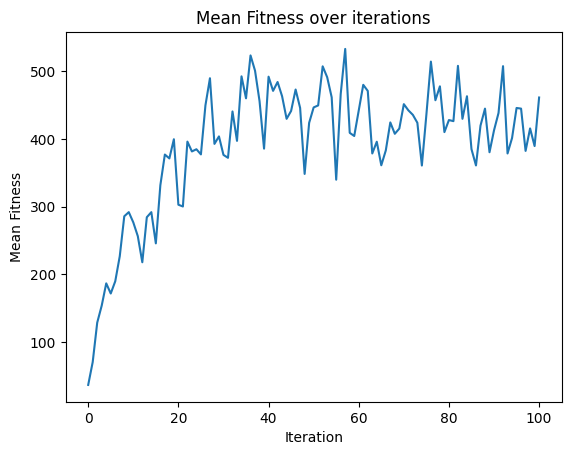

In [49]:
import numpy as np
import matplotlib.pyplot as plt

populationSize = 100
chromosomeSize = 100
seed = 42
maxWeight = 1000
#population = initializePopulation(populationSize, chromosomeSize, seed)
population = initializePopulationWithMaxWeight(populationSize, chromosomeSize, maxWeight, seed, 0.75)

def geneticAlgorithm(population: list[list], maxWeight: int, generations: int, elitSize: int, penaltyFactor: int = 1.5):
    
    meanFitness = []
    fitnessList = [calculateFitness(i, maxWeight, False, penaltyFactor) for i in population]
    mean = np.mean(fitnessList)
    meanFitness.append(mean)
    

    for i in range(generations):
        sortedPopulation = sortPopulation(population, maxWeight, False, penaltyFactor)
        new_population = sortedPopulation[:elitSize]
        while len(new_population) != len(population):
            
            #firstIndividual = tournamentSelection(population, 2, maxWeight, penaltyFactor)
            #secondIndividual = tournamentSelection(population, 2, maxWeight, penaltyFactor)
        
            firstIndividual = rouletteWheelSelection(population, maxWeight, penaltyFactor)
            secondIndividual = rouletteWheelSelection(population, maxWeight, penaltyFactor)
            
            #offsprings = singlePointCrossover(firstIndividual, secondIndividual)
            offsprings = uniformCrossover(firstIndividual, secondIndividual, maxWeight, penaltyFactor)
            #offsprings = multiplePointCrossover(firstIndividual, secondIndividual)
            offsprings[0] = mutation(offsprings[0], len(offsprings[0]))
            offsprings[1] = mutation(offsprings[1], len(offsprings[1]))

            new_population.extend(offsprings)

        population = new_population
        #print(f"Generation {i}")
        #print(population)
        
        fitnessList = [calculateFitness(i, maxWeight, False, penaltyFactor) for i in population]
        mean = np.mean(fitnessList)
        meanFitness.append(mean)
        
    x = np.arange(0, generations + 1)
    plt.plot(x, meanFitness)
    plt.title("Mean Fitness over iterations")
    plt.xlabel("Iteration")
    plt.ylabel("Mean Fitness")
    
    return population

generations = 100
elitismSize = 0
penaltyFactor = 1.2
new = geneticAlgorithm(population, maxWeight, generations, elitismSize, penaltyFactor)


In [50]:
sortedNew = sortPopulation(new, maxWeight, True, penaltyFactor)

for i in sortedNew:
    fitness = calculateFitness(i, maxWeight, True, penaltyFactor)
    totalWeight = 0
    totalProtein = 0
    
    for j in range(len(i)):
        if i[j]:  
            protein = df.iloc[j]['Protein (g)']
            weight = df.iloc[j]['Calories']
            totalProtein += protein
            totalWeight += weight

    print(f"Fitness {fitness}, calorie {totalWeight}, protein {totalProtein}")


print(sortedNew[0])
for i, value in enumerate(sortedNew[0]):
    if value == 1:
        print(f"Name: {df.iloc[i]['Name']}, Protein (g): {df.iloc[i]['Protein (g)']}, Calories: {df.iloc[i]['Calories']}")

Fitness 981.3, calorie 877.0, protein 98.13
Fitness 963.8, calorie 793.0, protein 96.38
Fitness 923.3925616361767, calorie 1033.0, protein 98.98
Fitness 912.4, calorie 784.0, protein 91.24
Fitness 905.8, calorie 658.0, protein 90.58
Fitness 887.2, calorie 627.0, protein 88.72
Fitness 886.8000000000001, calorie 946.0, protein 88.68
Fitness 875.4000000000001, calorie 855.0, protein 87.54
Fitness 870.4000000000001, calorie 728.0, protein 87.04
Fitness 867.8, calorie 951.0, protein 86.78
Fitness 867.5, calorie 945.0, protein 86.75
Fitness 867.4, calorie 880.0, protein 86.74
Fitness 861.5, calorie 855.0, protein 86.15
Fitness 859.2, calorie 810.0, protein 85.92
Fitness 848.6, calorie 946.0, protein 84.86
Fitness 835.7, calorie 756.0, protein 83.57000000000001
Fitness 830.8, calorie 752.0, protein 83.08
Fitness 825.7669451569859, calorie 1014.0, protein 84.95
Fitness 822.4, calorie 922.0, protein 82.24
Fitness 818.2, calorie 672.0, protein 81.82000000000001
Fitness 817.8, calorie 743.0, prot